<img src="http://vision.skills.network/logo-light.png" width="400" alt="CV Studio logo"  />


<h2>H.O.G. and SVM Image Classification with OpenCV and <a href="https://vision.skills.network/"> Computer Vision Learning Studio (CV Studio)</a></h2></h2>
<h3>Project: Age Detection</h3>
<h3>Training Run: Age Detection</h3>


## Objectives


We will be classifying images using <code>Sklearn</code> and <a href="https://vision.skills.network/"> Computer Vision Learning Studio (CV Studio)</a>. CV Studio is a fast, easy and collaborative open-source Computer Vision tool for teams and individuals. If you created a separate folder for each image class, the tool will do the labeling for you. H.O.G. combined with SVM was one of the ways image classification was done before more advanced methods like Deep Learning became popular.


<ul>
    <li>This tool contains the following sections:
        <ul>
            <li>Import Libraries</li>
            <li>Image Files and Paths  </li>
            <li>Plotting an Image </li>
            <li>H.O.G. as a feature descriptor </li>
            <li>SVM for Image classification </li>
            <li>Save the model to CVStudio</li>
        </ul>
    </li>
</ul>


----


## Import Important Libraries and Define Auxilary Functions


Libraries for data processing and visualization:


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from imutils import paths
import seaborn as sns
import random
import time
from datetime import datetime

Libraries for image pre-processing and classification:


In [2]:
import cv2
import joblib
from skimage.feature import hog
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Libraries for OS and Cloud:


In [3]:
import os
from skillsnetwork import cvstudio

I will load and process every image. Let's go over some concepts:

<ul>
        <ul>
            <li><code>cv2.resize()</code> to resize the image </li>
            <li><code>cv2.COLOR_BGR2GRAY()</code> will convert the images to greyscale image</li>
            <li><code>hog()</code> will get the H.O.G. features from the image </li>
        </ul>
    
</ul>

I will use this function to read and preprocess the images, the function will be explained in the **Histogram of Oriented Gradients (H.O.G.)** section.


In [4]:
def load_images(image_paths):
# loop over the input images
    for (i, image_path) in enumerate(image_paths):
        #read image
        image = cv2.imread(image_path)
        image = np.array(image).astype('uint8')
        image = cv2.resize(image, (64, 64))
        grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        hog_features, hog_images = hog(grey_image,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))
        #label image using the annotations
        label = class_object.index(annotations["annotations"][image_path[7:]][0]['label'])
        train_images.append(hog_features)
        train_labels.append(label)


## Download Images and Annotations
I will train and classify them using the SVM classifier using the <code>Sklearn</code> library. Before I start, let's get the images and take a look at some of them.


In [5]:
# Initialize the CV Studio Client
cvstudioClient = cvstudio.CVStudio()

# Download All Images
cvstudioClient.downloadAll()

100%|██████████| 150/150 [00:56<00:00,  2.66it/s]


Get the annotations from CV Studio:


In [6]:
annotations = cvstudioClient.get_annotations()

Let's view the format of the annotations I've just downloaded. The following code will display only the first 5 annotations. The annotations will come in a JSON file. What you can see is the image name as the key and Age range as label object.


In [7]:
first_five = {k: annotations["annotations"][k] for k in list(annotations["annotations"])[:5]}
first_five

{'0faf93e3-3be1-4a11-b03b-d550d1d3bf70.jpg': [{'label': '18-20',
   'id': 'ea88826d-3434-4286-9d16-544a37e3cec8'}],
 '1ceaf95b-d81a-4065-9184-eea91b3af332.jpg': [{'label': '18-20',
   'id': 'd505f001-5b32-4aa3-91c0-7f44ebbe46a3'}],
 '26fd8179-792a-4f68-af4c-2a6287856f71.jpg': [{'label': '18-20',
   'id': '2d11cc2c-79a0-47ce-a9d3-ae11813eacf9'}],
 '270bb887-8e10-4bfa-9097-8e7845c201cd.jpg': [{'label': '18-20',
   'id': '814d76a4-1615-4950-8f41-556d395eb6da'}],
 '5327a13d-6edd-4bba-b407-0ed7580b5638.jpg': [{'label': '18-20',
   'id': '71dc0b5b-57ca-4852-960a-ae47b19fdf0a'}]}

## Histogram of Oriented Gradients (H.O.G.)


H.O.G. generates a histogram for each localized region. I will pick a random image and see how H.O.G. works.


In [8]:
sample_image = 'images/' + random.choice(list(annotations["annotations"].keys()))

To create H.O.G. features, I will first convert the image to a grayscale image.


In [9]:
sample_image = cv2.imread(sample_image)

Resize the image to a smaller size to allow the algorithm to run faster and convert the images to the grayscale to reduce the number of channels. `OpenCV` reads images as `BGR` so I will be using that color channel to convert to grayscale. 

Early developers at `OpenCV` chose `BGR` color format because it was the format that was popular among camera manufacturers and software providers.


In [10]:
sample_image = cv2.resize(sample_image, (64, 64))
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)

Plot the data to look at what it looks like:


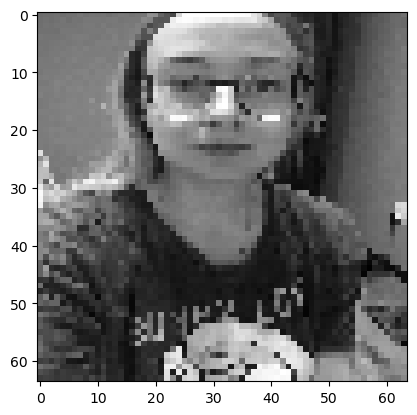

In [11]:
plt.imshow(sample_image, cmap=plt.cm.gray)

Run H.O.G. on the grayscale image to see what it will look like.

H.O.G. stands for Histogram of Oriented Gradients. It uses the gradient orientation of the localized regions of an image and generates a histogram for each localized region.


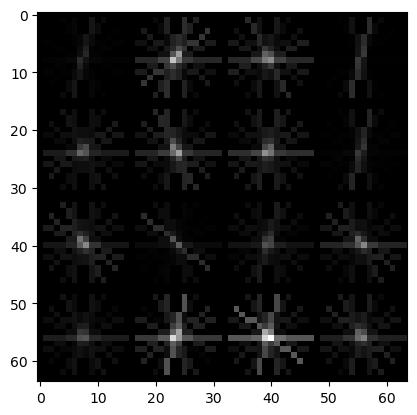

In [12]:
## when we run H.O.G., it returns an array of features and the image/output it produced
## the featurre is what we use to train the SVM model
sample_image_features, sample_hog_image = hog(sample_image,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

## lets look at what the H.O.G. feature looks like
plt.imshow(sample_hog_image, cmap=plt.cm.gray)

## Load Images and Generate Training/Testing Dataset


Initiate a location for saving loaded images:


In [13]:
image_paths = list(paths.list_images('images'))
train_images = []
train_labels = []
class_object = annotations['labels']

Use the function on the image path:


In [14]:
load_images(image_paths)

Create an array of the images and use the <code>np.vstack</code> to vertically stack arrays for wrangling.


In [15]:
train_array = np.array(train_images)
train_array = np.vstack(train_array)

I will <code>reshape</code> the array to <code>(label size, 1)</code>. The array will look like this: <code>[[1], [0], ..., [0]]</code></p>


In [16]:
labels_array = np.array(train_labels)

In [17]:
labels_array = labels_array.astype(int)
labels_array = labels_array.reshape((labels_array.size,1))

Concatenate the images and labels:


In [18]:
train_df = np.concatenate([train_array, labels_array], axis = 1)

Divide the data into a training and test set:


In [19]:
percentage = 75
partition = int(len(train_df)*percentage/100)

In [20]:
x_train, x_test = train_df[:partition,:-1],  train_df[partition:,:-1]
y_train, y_test = train_df[:partition,-1:].ravel(), train_df[partition:,-1:].ravel()

## Hyperparameters


The kernel type to be used is a hyperparameter. The most common kernels are <code>RBF</code>, <code>poly</code>, or <code>sigmoid</code>.

<code>C</code> behaves as a regularization parameter in the SVM. The <code>C</code> parameter trades off correct classification of the training examples against the maximization of the decision function’s margin. For larger values of <code>C</code>, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower <code>C</code> will encourage a larger margin, therefore a simpler decision function at the cost of accuracy. I select C and the best kernel by using the validation data. 


The  python dictionary <code>param_grid</code>  has different kernels and values of C. I can test them using the validation data.


In [21]:
param_grid = {'kernel': ('linear', 'rbf'),'C': [1, 10, 100]}

<code>gamma</code> is a parameter of the RBF kernel and can be thought of as the spread of the kernel and, therefore, the decision region. Low values mean ‘far’ and high values mean ‘close’. The behaviour of the model is very sensitive to the gamma parameter. If gamma is too large, the radius of the area of influence of the support vectors only includes the support vector itself. I create a Support Vector Classification object.


## Support Vector Machines


In [22]:
base_estimator = SVC(gamma='scale')

I will train the model and try different kernels and parameter values using the function <code>GridSearchCV</code>. The resulting output will be the model that performs best on the validation data. 


In [23]:
start_datetime = datetime.now()
start = time.time()

svm = GridSearchCV(base_estimator, param_grid, cv=5)
#Fit the data into the classifier
svm.fit(x_train,y_train)
#Get values of the grid search
best_parameters = svm.best_params_
print(best_parameters)
#Predict on the validation set
y_pred = svm.predict(x_test)
# Print accuracy score for the model on validation  set. 
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))

end = time.time()
end_datetime = datetime.now()
print(end - start)

{'C': 10, 'kernel': 'rbf'}
Accuracy: 0.3157894736842105
0.28450822830200195


**Accuracy** is the number the model got right over the total number of predictions. This is (TP+TN)/Total Number of Predictions.


Get Confusion Matrix for SVM results:


In [24]:
label_names = [0, 1, 2, 3, 4]
cmx = confusion_matrix(y_test, y_pred, labels=label_names)

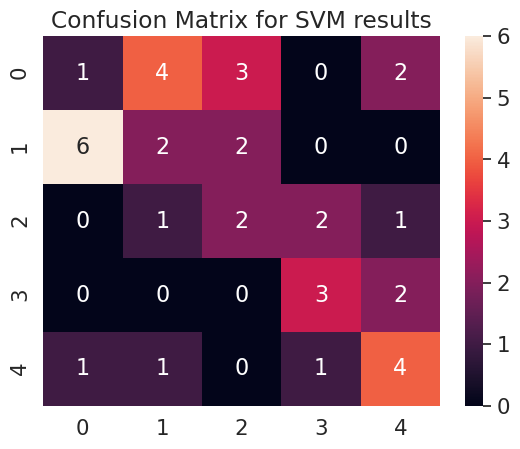

In [25]:
df_cm = pd.DataFrame(cmx)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
title = "Confusion Matrix for SVM results"
plt.title(title)
plt.show()

## Let's Report Our Results Back to CV Studio


In [26]:
parameters = {
    'best_params': best_parameters
}
result = cvstudioClient.report(started=start_datetime, completed=end_datetime, parameters=parameters, accuracy=accuracy_score(y_test, y_pred))

if result.ok:
    print('Congratulations your results have been reported back to CV Studio!')

Congratulations your results have been reported back to CV Studio!


In [27]:
# Save the SVM model to a file
joblib.dump(svm.best_estimator_, 'svm.joblib')

['svm.joblib']

In [28]:
# Now let's save the model back to CV Studio
result = cvstudioClient.uploadModel('svm.joblib', {'svm_best': svm.best_estimator_})

File Uploaded
